# imports, read data, and preprocessing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as lng
import subprocess
import os
import struct
import time
import math

def readImages(file):
    with open(file.split('.')[0], 'rb') as f:
        magic_num, size = struct.unpack(">II", f.read(8))
        rows, cols = struct.unpack(">II", f.read(8))
        data = np.frombuffer(f.read(),dtype=np.dtype(np.uint8).newbyteorder(">"))
        data = data.astype(np.float32)
        data = data.reshape((size, rows * cols))
    return data

def readLabels(file):
    with open(file.split('.')[0], 'rb') as f:
        magic_num, size = struct.unpack(">II", f.read(8))
        data = np.frombuffer(f.read(),dtype=np.dtype(np.uint8).newbyteorder(">"))
        data = data.reshape((size))
    data = np.array([data[i]//5 for i in range(size)])
    data_ohe = np.zeros((data.shape[0], data.max()+1))
    data_ohe[np.arange(data.shape[0]), data] = 1
    return data_ohe, data

x_train = readImages('train-images-idx3-ubyte')
y_train_ohe, y_train = readLabels('train-labels-idx1-ubyte')
x_test = readImages('t10k-images-idx3-ubyte')
y_test_ohe, y_test = readLabels('t10k-labels-idx1-ubyte')

# z-normalize data
# x_train = (x_train-np.mean(x_train))/np.std(x_train)
with np.errstate(divide='ignore',invalid='ignore'):
    tr_std = np.std(x_train,axis=0)
    tr_std = np.where(tr_std != 0, tr_std, 1)
#     x_train = np.nan_to_num((x_train - np.mean(x_train))/np.std(x_train)) # 
    x_train = np.nan_to_num((x_train - np.mean(x_train,axis=0))/tr_std) # across data
#     x_test = np.nan_to_num((x_test - np.mean(x_train))/ np.std(x_train))
    x_test = np.nan_to_num((x_test - np.mean(x_train,axis=0))/tr_std) # normalize according to mean and std of train

# concatenate 1 to the end
c = np.array([[1 for i in range(60000)]])
ct = np.array([[1 for i in range(10000)]])
x_train = np.concatenate((x_train, c.T), axis=1)
x_test = np.concatenate((x_test, ct.T), axis=1)

# baseline

In [2]:
def minibatch_SGD(B, itrs, eta, train_x, train_y, x_test, y_test):
    weights, v_weights, loss, te_loss = [], [], [], []
    W = np.zeros((785,2)) ## Baseline
    interv = np.linspace(1,itrs,num=5)
    interv = [math.floor(i) for i in interv]
    te_err_list, tr_err_list = [], []
    for i in range(itrs): 
        r = np.random.choice(len(train_x), size=B, replace=False)
        X = train_x[r,:] 
        Y = train_y[r]
        # update weights: W
        g = W.T.dot(X.T) # 2 x B
        g = X.T.dot(g.T) - (X.T.dot(Y)) # 785 x 2
        W -= eta/B*g
        weights.append(W)
        if i in interv:
            print("Num iters: {}".format(i))
        train_bool = X@W 
        test_bool = x_test@W 
        tr_err = 1-((np.argmax(train_bool, axis=1) == np.argmax(Y,axis=1)).sum()) / Y.shape[0]
        te_err = 1-((np.argmax(test_bool, axis=1) == np.argmax(y_test,axis=1)).sum()) / y_test.shape[0] 
        tr_err_list.append(100*tr_err)
        te_err_list.append(100*te_err)
        loss.append(0.5*np.square(lng.norm(Y - train_bool)/B)) 
        te_loss.append(0.5*np.square(lng.norm(y_test - test_bool)/10000)) 
    return weights, loss, tr_err_list, te_loss, te_err_list

Num iters: 1
Num iters: 250
Num iters: 500
Num iters: 750


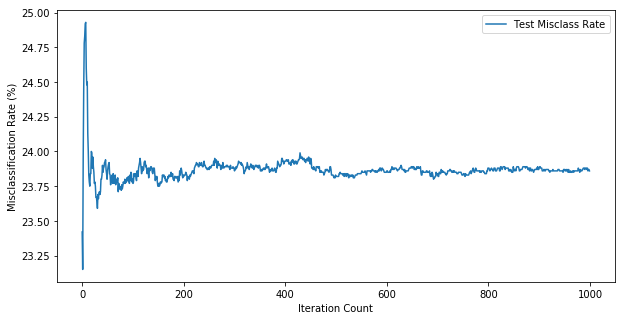

In [3]:
iters = 1000
w, l, tr_err_list, te_l, te_err_list = minibatch_SGD(500, iters, 10**-12, x_train, y_train_ohe, x_test, y_test_ohe)
fig = plt.figure(figsize=(10,5))
# plt.plot(np.arange(iters),tr_err_list,label='Training Misclass Rate')
plt.plot(np.arange(iters),te_err_list,label='Test Misclass Rate')
plt.ylabel('Misclassification Rate (%)')
plt.xlabel('Iteration Count')
plt.legend()
plt.savefig('part2')
plt.show()

# neural net; quadratic loss

In [4]:
def relu(x):
    return np.maximum(x,0)

def predict(W,V,x,lfn):
    if lfn == 'ql':
        return V@(relu(W.T@x.T))
    elif lfn == 'll':
        return 1/(1+math.e**-(V@(relu(W.T@x.T))))

def update_weights(W,V,x,y,eta,lfn):
    # QL
    t = relu(W.T@x)
    d_relu = np.where(t > 0,1,0)
    est_y = V@t 
    if lfn == 'll':
        est_y = 1/(1+math.e**-(est_y))
    res = est_y-y
    W -= (eta*res*np.multiply(V.T,d_relu)@x.T).T 
    V -= (eta*res*t).T
    return W, V

In [13]:
def nn_SGD(B, itrs, eta, train_x, train_y, x_test, y_test, epochs, k):
    W_QL, W_LL = np.random.normal(0, 1/k, ((785,k))), np.random.normal(0, 1/k, ((785,k))) 
    V_QL, V_LL = np.random.normal(0, 1/100, ((1,k))), np.random.normal(0, 1/100, ((1,k))) 
    interv = [math.floor(i) for i in np.linspace(1,itrs,num=5)]
    te_err_list, tr_err_list = [], []
    te_err_list_ll, tr_err_list_ll = [], []
    tr_err, te_err = 0,0
    tr_err_ll, te_err_ll = 0,0
    count = 0
    
    for epoch in range(epochs):
        print("Epoch: {}".format(epoch))
        r = np.random.choice(np.arange(60000),60000, replace=False)
        for i in range(itrs):  
            X = train_x[r[i],:].reshape((785,1)) 
            Y = train_y[r[i]]
            
            W_QL, V_QL = update_weights(W_QL,V_QL,X,Y,eta,'ql')
            W_LL, V_LL = update_weights(W_LL,V_QL,X,Y,eta,'ll')
            
            if i in interv:
                print("Num iters: {}".format(i))
            if count % 1000 == 0:
                tr_output = predict(W_QL,V_QL,train_x,'ql') # sigma(x) = x
                tr_output_ll = predict(W_LL,V_LL,train_x,'ll') # s(x) = logistic fn
                
                tr_output = np.where(tr_output >= 0.5, 1, 0)
                tr_output_ll = np.where(tr_output_ll >= 0.5, 1, 0)
                
                tr_err = 1 - ((tr_output == train_y).sum())/60000
                tr_err_ll = 1 - ((tr_output_ll == train_y).sum())/60000
                
                tr_err_list.append(100*tr_err)
                tr_err_list_ll.append(100*tr_err_ll)
                
                
                test_output = predict(W_QL,V_QL,x_test,'ql') # 1x10k; sigma(x) = x
                test_output_ll = predict(W_LL,V_LL,x_test,'ll') # logistic
                
                test_output = np.where(test_output >= 0.5, 1, 0)
                test_output_ll = np.where(test_output_ll >= 0.5, 1, 0)
                
                te_err = 1 - ((test_output == y_test).sum())/10000
                te_err_ll = 1 - ((test_output_ll == y_test).sum())/10000
                
                te_err_list.append(100*te_err)
                te_err_list_ll.append(100*te_err_ll)
                
            count += 1
    return tr_err_list, te_err_list, tr_err_list_ll, te_err_list_ll

Epoch: 0
Num iters: 1
Num iters: 15000
Num iters: 30000
Num iters: 45000
Epoch: 1
Num iters: 1
Num iters: 15000
Num iters: 30000
Num iters: 45000
Epoch: 2
Num iters: 1
Num iters: 15000
Num iters: 30000
Num iters: 45000
Epoch: 3
Num iters: 1
Num iters: 15000
Num iters: 30000
Num iters: 45000
Epoch: 4
Num iters: 1
Num iters: 15000
Num iters: 30000
Num iters: 45000


/Users/audrey_der/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if sys.path[0] == '':
/Users/audrey_der/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  del sys.path[0]
/Users/audrey_der/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/Users/audrey_der/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


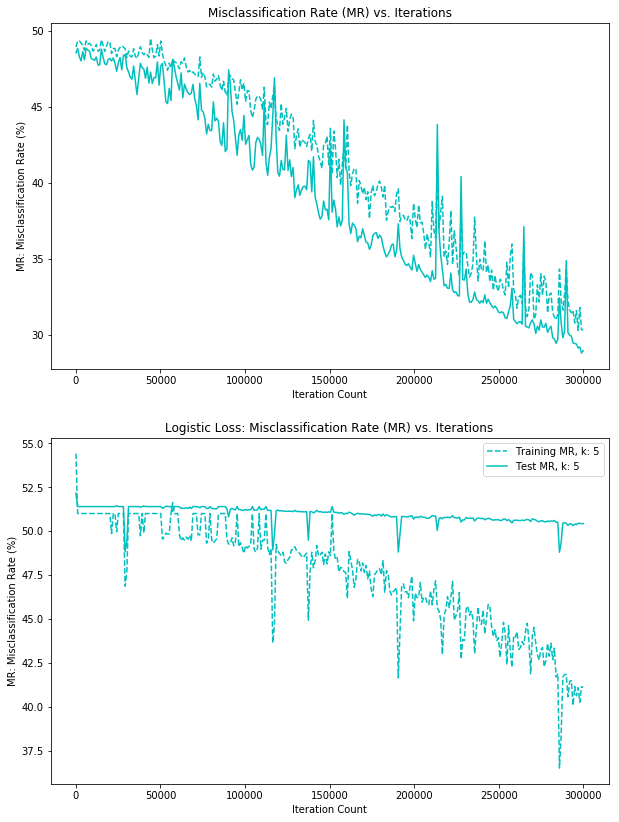

In [14]:
fig = plt.figure(figsize=(10,14))
itrs = 60000 
eta = 10**-4.2
epochs = 5
colors = ['c','m','y']
j = 0

for k in [5,40,200]:
    tr_mr, te_mr, tr_mr_ll, te_mr_ll = nn_SGD(1, itrs, eta, x_train, y_train, x_test, y_test, epochs, k)
    
    plt.subplot(2, 1, 1)
    plt.plot(np.linspace(0,300000,num=itrs*epochs/1000), tr_mr, color=colors[j], linestyle='--', label = 'Training MR, k: {}'.format(k))
    plt.plot(np.linspace(0,300000,num=itrs*epochs/1000), te_mr, color=colors[j], label='Test MR, k: {}'.format(k))
    plt.ylabel('MR: Misclassification Rate (%)')
    plt.xlabel('Iteration Count')
    plt.title('Misclassification Rate (MR) vs. Iterations')
    
    plt.subplot(2, 1, 2)
    plt.plot(np.linspace(0,300000,num=itrs*epochs/1000), tr_mr_ll, color=colors[j], linestyle='--', label = 'Training MR, k: {}'.format(k))
    plt.plot(np.linspace(0,300000,num=itrs*epochs/1000), te_mr_ll, color=colors[j], label='Test MR, k: {}'.format(k))
    plt.ylabel('MR: Misclassification Rate (%)')
    plt.xlabel('Iteration Count')
    plt.title('Logistic Loss: Misclassification Rate (MR) vs. Iterations')
    
    j += 1
    break
    
plt.legend()
plt.savefig('TEMP')
plt.show()